# Support Vector Regression with Stochastic Gradient Descent (Ticker Data)

# References

* http://leon.bottou.org/publications/pdf/compstat-2010.pdf
* http://research.microsoft.com/pubs/192769/tricks-2012.pdf
* http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1257413&tag=1
* http://www.sciencedirect.com/science/article/pii/S0305048301000263
* http://link.springer.com/book/10.1007/978-3-642-35289-8

In [4]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

%load_ext version_information
%version_information deap, matplotlib, numpy, pandas, seaborn, sklearn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.5.1 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 4.1.2
OS Linux 3.13.0 86 generic x86_64 with debian jessie sid
deap 1.0
matplotlib 1.5.1
numpy 1.10.4
pandas 0.18.0
seaborn 0.7.0
sklearn 0.17.1
Fri May 27 13:54:40 2016 BST

In [150]:
from deap import base, creator, tools, algorithms
from IPython.display import display
from ipywidgets import widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing as preproc
from sklearn import svm
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

np.set_printoptions(threshold=np.nan)
sns.set()
sns.set_color_codes()
sns.set_context("notebook", font_scale=1.35)
toolb = base.Toolbox()

In [7]:
path = '../btc-data/BTC_Trades_techind_30s.csv'
data30s = pd.read_csv(path, index_col = 0, parse_dates = True)

path = '../btc-data/BTC_Trades_techind_60s.csv'
data1m = pd.read_csv(path, index_col = 0, parse_dates = True)

path = '../btc-data/BTC_Trades_techind_300s.csv'
data5m = pd.read_csv(path, index_col = 0, parse_dates = True)

path = '../btc-data/BTC_Trades_techind_600s.csv'
data10m = pd.read_csv(path, index_col = 0, parse_dates = True)

In [8]:
data30s

,Price,K360,K180,K60,D360,D180,D60,sD360,sD180,sD60,...,DISP60,OSCP180-360,OSCP60-180,RSI360,RSI180,RSI60,CCI360,CCI180,CCI60,DELTAP
2016-02-02 06:58:38,372.52,13.588850,8.148148,12.716763,62.456425,49.315279,22.895471,76.610950,75.042273,25.494617,...,99.860471,0.000729,-0.001101,49.739935,49.123461,45.067265,0.320664,-0.670980,-1.446046,0.00
2016-02-02 06:59:08,373.09,13.588850,8.148148,12.716763,62.355947,48.804991,22.680066,76.529835,74.916225,25.355198,...,99.864397,0.000715,-0.001128,50.253017,48.469966,45.067265,0.315882,-0.680146,-1.401352,0.57
2016-02-02 06:59:38,373.09,33.449477,29.259259,45.664740,62.310638,48.411987,23.013795,76.448752,74.785223,25.229498,...,100.018587,0.000705,-0.001138,50.798845,49.556213,48.366702,0.789845,-0.173456,-0.566770,0.00
2016-02-02 07:00:08,373.09,33.449477,29.259259,45.664740,62.265329,48.018983,23.625301,76.367701,74.649268,25.126773,...,100.018810,0.000695,-0.001137,50.798845,49.556213,49.729144,0.786000,-0.182919,-0.542314,0.00
2016-02-02 07:00:38,373.09,33.449477,29.259259,45.664740,62.157553,47.625979,24.236808,76.286334,74.509600,25.039942,...,100.019034,0.000689,-0.001135,50.349650,49.556213,49.729144,0.781612,-0.192548,-0.517869,0.00
2016-02-02 07:01:08,373.09,33.449477,29.259259,45.664740,62.049777,47.232974,24.570536,76.204653,74.366179,24.959746,...,100.020419,0.000683,-0.001146,50.349650,49.556213,48.272018,0.777241,-0.202352,-0.492211,0.00
2016-02-02 07:01:38,373.25,33.449477,29.259259,45.664740,62.002617,46.839970,24.904265,76.122993,74.219003,24.899655,...,100.021805,0.000676,-0.001156,50.349650,49.556213,48.272018,0.772765,-0.212339,-0.466282,0.16
2016-02-02 07:02:08,373.25,39.024390,35.185185,54.913295,61.970942,46.479888,25.318233,76.041628,74.068257,24.859776,...,100.065370,0.000671,-0.001162,50.503486,49.852941,49.178532,0.904226,-0.071653,-0.189571,0.00
2016-02-02 07:02:38,373.25,39.024390,35.185185,54.913295,61.872790,46.119806,25.732202,75.960188,73.914698,24.836915,...,100.066040,0.000668,-0.001167,50.233645,49.852941,49.178532,0.899335,-0.081622,-0.162706,0.00
2016-02-02 07:03:08,373.25,39.024390,35.185185,54.913295,61.774638,45.759723,26.501224,75.878674,73.758327,24.842907,...,100.065370,0.000665,-0.001159,50.233645,49.852941,50.849377,0.894467,-0.091779,-0.145698,0.00


In [9]:
data1m

,Price,K360,K180,K60,D360,D180,D60,sD360,sD180,sD60,...,DISP60,OSCP180-360,OSCP60-180,RSI360,RSI180,RSI60,CCI360,CCI180,CCI60,DELTAP
2016-02-02 15:57:38,375.00,96.192385,92.720307,100.000000,57.648247,78.584338,62.241765,45.923501,69.741715,46.297091,...,100.220558,0.002065,0.000282,51.665885,53.562200,57.821553,1.361923,1.657565,2.283489,0.20
2016-02-02 15:58:38,374.80,100.000000,100.000000,100.000000,57.841821,78.677735,63.613193,45.925769,69.928117,46.568136,...,100.266531,0.002082,0.000325,51.567398,53.902528,59.655172,1.569055,1.766314,2.948180,-0.20
2016-02-02 15:59:38,374.80,96.000000,92.366412,90.697674,58.069773,78.693298,64.867678,45.929089,70.112271,46.877834,...,100.206268,0.002091,0.000367,51.786558,53.135314,58.577878,1.371810,1.628471,2.347402,0.00
2016-02-02 16:00:38,374.80,96.000000,92.366412,89.473684,58.300628,78.712080,66.358906,45.933478,70.294180,47.234310,...,100.197561,0.002099,0.000428,51.811024,53.174312,61.565836,1.370528,1.612407,2.740133,0.00
2016-02-02 16:01:38,374.95,96.000000,92.366412,89.473684,58.567295,78.713150,67.152054,45.939244,70.473251,47.614295,...,100.192428,0.002103,0.000455,52.114684,52.984525,57.536042,1.366833,1.596165,2.539967,0.15
2016-02-02 16:02:38,374.49,99.000000,98.091603,97.368421,58.842295,78.736364,68.111685,45.946411,70.649552,48.013908,...,100.226542,0.002105,0.000490,52.585521,53.139919,58.656331,1.504576,1.669577,2.621804,-0.46
2016-02-02 16:03:38,374.95,89.800000,76.279070,73.157895,59.015982,78.776884,68.657224,45.954551,70.824791,48.435967,...,100.099657,0.002122,0.000497,51.514180,53.932165,55.365854,1.054976,1.665384,1.684395,0.46
2016-02-02 16:04:38,375.00,99.000000,97.674419,97.368421,59.190814,78.773626,69.575931,45.963404,70.998092,48.885770,...,100.216764,0.002130,0.000533,51.645893,52.968037,57.589803,1.500395,1.922833,2.366635,0.05
2016-02-02 16:05:38,375.00,100.000000,100.000000,100.000000,59.383575,78.802611,70.672188,45.973036,71.169574,49.368225,...,100.223387,0.002138,0.000574,51.833467,53.300267,58.851114,1.544356,1.929849,2.307969,0.00
2016-02-02 16:06:38,374.49,100.000000,100.000000,100.000000,59.576336,78.823545,72.116038,45.983437,71.339146,49.894920,...,100.214905,0.002146,0.000634,51.833467,53.211009,61.670762,1.539678,1.906751,2.659205,-0.51


In [10]:
data5m

,Price,K360,K180,K60,D360,D180,D60,sD360,sD180,sD60,...,DISP60,OSCP180-360,OSCP60-180,RSI360,RSI180,RSI60,CCI360,CCI180,CCI60,DELTAP
2016-02-05 15:49:38,387.99,83.853119,82.795699,71.830986,85.563941,60.423892,76.702545,68.261256,74.036084,80.094739,...,100.035825,0.006598,0.002359,55.570264,50.512645,52.364360,0.953797,0.601820,0.904864,-0.61
2016-02-05 15:54:38,388.16,80.784708,69.677419,50.352113,85.557149,60.361905,76.234055,68.367920,73.869704,80.284157,...,99.875838,0.006488,0.002388,55.328893,49.991544,51.695332,0.900988,0.473635,0.399187,0.17
2016-02-05 15:59:38,388.50,81.639839,73.333333,56.338028,85.553423,60.325818,75.706355,68.474420,73.703736,80.452210,...,99.917242,0.006381,0.002407,55.389201,50.304569,51.360713,0.911648,0.498754,0.518882,0.34
2016-02-05 16:04:38,388.64,83.350101,80.645161,57.547170,85.558243,60.324764,75.737270,68.580787,73.538294,80.620222,...,99.996439,0.006274,0.002483,55.536332,50.422012,54.974359,0.936500,0.557901,1.543157,0.14
2016-02-05 16:09:38,388.39,84.054326,83.655914,61.616162,85.565709,60.312769,75.466770,68.687032,73.373154,80.774541,...,100.026638,0.006153,0.002546,55.587056,49.700291,53.594080,0.945092,0.577522,1.902187,-0.25
2016-02-05 16:14:38,388.39,82.796781,78.279570,48.989899,85.563471,60.266715,74.852499,68.793109,73.208173,80.912651,...,99.958650,0.006029,0.002593,55.435759,49.358865,52.247488,0.921297,0.518968,1.723290,0.00
2016-02-05 16:19:38,388.54,82.796781,78.279570,48.989899,85.560888,60.236030,74.002330,68.899017,73.043521,81.026849,...,99.959979,0.005914,0.002582,55.432679,49.827408,49.126761,0.918391,0.510564,1.680609,0.15
2016-02-05 16:24:38,388.80,83.551308,81.505376,56.565657,85.560401,60.221310,73.278425,69.004710,72.879276,81.117888,...,100.000043,0.005798,0.002570,55.478837,49.896587,49.040632,0.928249,0.532641,1.800482,0.26
2016-02-05 16:29:38,388.96,84.859155,87.096774,69.696970,85.565272,60.246596,72.773374,69.110205,72.715688,81.194719,...,100.067475,0.005689,0.002558,55.577772,50.396825,49.665552,0.947693,0.577321,2.031600,0.16
2016-02-05 16:34:38,388.98,85.663984,90.537634,77.777778,85.573068,60.300220,72.410997,69.215510,72.552955,81.258969,...,100.108398,0.005585,0.002547,55.634385,50.821942,50.165929,0.958871,0.601752,2.128316,0.02


In [11]:
data10m

,Price,K360,K180,K60,D360,D180,D60,sD360,sD180,sD60,...,DISP60,OSCP180-360,OSCP60-180,RSI360,RSI180,RSI60,CCI360,CCI180,CCI60,DELTAP
2016-02-09 09:30:38,371.89,24.373119,27.898967,81.543624,24.939969,33.397432,36.749782,39.588132,42.888992,21.088897,...,100.222627,-0.001985,-0.006983,49.257669,47.167102,51.938308,-1.500696,-0.951494,-0.529665,-0.56
2016-02-09 09:40:38,371.96,18.756269,21.469575,62.751678,24.931137,33.240129,37.646787,39.471033,42.849181,21.469511,...,100.067494,-0.002025,-0.006869,48.807328,47.001431,52.068533,-1.575963,-1.064863,-0.797692,0.07
2016-02-09 09:50:38,372.59,19.458375,22.273249,65.100671,24.917242,33.125660,38.556359,39.354255,42.808238,21.866422,...,100.082020,-0.002053,-0.006765,48.677966,47.345017,52.008368,-1.554966,-1.037644,-0.735523,0.63
2016-02-09 10:00:38,373.64,25.777332,29.506315,86.241611,24.944278,33.014604,39.680057,39.237963,42.765692,22.282275,...,100.246722,-0.002096,-0.006659,49.361359,47.461830,52.228238,-1.449488,-0.886982,-0.382604,1.05
2016-02-09 10:10:38,373.02,36.308927,41.561424,100.000000,24.998523,32.970520,41.022428,39.122244,42.721940,22.725655,...,100.519853,-0.002129,-0.006523,49.645478,48.171988,54.156675,-1.281893,-0.644424,0.530207,-0.62
2016-02-09 10:20:38,373.79,30.090271,34.443169,82.872928,25.018837,32.886891,42.239523,39.006958,42.676966,23.197143,...,100.343607,-0.002159,-0.006376,49.100019,47.790549,54.200000,-1.367875,-0.774147,0.205859,0.77
2016-02-09 10:30:38,373.00,37.813440,43.283582,100.000000,25.084567,32.890745,43.586439,38.892290,42.631209,23.687051,...,100.540282,-0.002188,-0.006238,49.844527,48.593969,54.599524,-1.243644,-0.594310,0.706621,-0.79
2016-02-09 10:40:38,373.27,29.889669,34.213548,79.045093,25.117766,32.828222,44.552980,38.778124,42.584371,24.187219,...,100.321405,-0.002221,-0.006127,49.375272,47.979288,52.741313,-1.355192,-0.762556,0.294993,0.27
2016-02-09 10:50:38,373.98,32.597793,37.313433,86.206897,25.143292,32.794112,45.579462,38.664409,42.536877,24.703312,...,100.387364,-0.002242,-0.006018,49.131793,48.241079,52.850539,-1.306544,-0.693782,0.457675,0.71
2016-02-09 11:00:38,373.42,39.719157,45.464983,100.000000,25.203795,32.810085,46.841488,38.551285,42.488827,25.235179,...,100.568349,-0.002264,-0.005888,49.677662,48.736868,54.146341,-1.192288,-0.527301,0.958244,-0.56


In [151]:
def accuracy(act, pred):
    act_ticks = list(map(lambda x: 1 if x >= 0 else 0, act.values))
    pred_ticks = list(map(lambda x: 1 if x >= 0 else 0, pred))
    d = list(map(lambda t: t[0] == t[1], zip(act_ticks, pred_ticks)))
    
    return np.sum(d) / len(act_ticks)

In [153]:
def fitness_fun(model):
    method, indiv, dataset = model
    
    X_train, X_valid, y_train, y_valid = dataset
    
    # Sometimes the GA assigns the value 0 or less
    # to the parameters, causing the model to fail.
    # The lines below prevent this.
    if indiv[0] <= 0:
        indiv[0] = 0.0001
        
    if indiv[1] <= 0:
        indiv[1] = 0.002
        
    method.alpha = indiv[0]
    method.eta0 = indiv[1]
    
    method.fit(X_train, y_train)
    
    pred = method.predict(X_valid)
    rmse = np.sqrt(mse(y_valid, pred))
    dir_sym = accuracy(y_valid, pred)
    
    return dir_sym, rmse

def nsga2_feat_sel(method, gen_num, indiv_num, dataset):
    # GA configuration
    creator.create("FitnessMulti", base.Fitness, weights = (1.0, -1.0))
    creator.create("Individual", list, fitness=creator.FitnessMulti)
    toolb.register('alpha', random.uniform, 1e-8, 0.01)
    toolb.register('eta0', random.uniform, 0.0001, 0.01)
    toolb.register('individual', tools.initCycle, creator.Individual, 
                   (toolb.alpha, toolb.eta0), n = 1)
    toolb.register('population', tools.initRepeat, list, toolb.individual, n = indiv_num)
    toolb.register('evaluate', fitness_fun)
    toolb.register('mate', tools.cxUniform, indpb = 0.1)
    toolb.register('mutate', tools.mutGaussian, mu = 0.0001, sigma = 0.001, indpb = 0.1)
    toolb.register('select', tools.selNSGA2)

    # Initialise the population and the fitness function
    population = toolb.population()
    fits = map (toolb.evaluate, map(lambda x: (method, x, dataset), population))

    # Initialize the placeholder
    # for the best individuals
    hof = tools.HallOfFame(1)
    
    # Run the fitness function on the population
    for fit, ind in zip(fits, population):
        ind.fitness.values = fit

    best = np.ndarray((gen_num, 2))

    # Start the evolution
    for gen in range(gen_num):
        offspring = algorithms.varOr(population, toolb, lambda_ = indiv_num, cxpb = 0.55, mutpb = 0.15)
        hof.update(offspring)

        fits = map (toolb.evaluate, map(lambda x: (method, x, dataset), offspring))

        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        population = toolb.select(offspring + population, k = indiv_num)

        best[gen] = (hof[0].fitness.values)

    chromosome = hof[0]
    
    return best, method, chromosome

In [154]:
def feature_selection(gen_num, indiv_num, model, dataset):
    results = nsga2_feat_sel(model, gen_num, indiv_num, dataset)
    
    best_model = results[1]
    chromosome = results[2]

    print ('Scores', results[0], '\n')
    print ('Chromosome: ', chromosome, '\n')
    
    # Create dataframes from the metrics
    results_df = pd.DataFrame(results[0], columns = ['Accuracy', 'RMSE'])
    results_df.insert(0, 'Generation', results_df.index)
    
    # Plot the best individuals of each generation based on the metrics
    g = sns.PairGrid(results_df, y_vars=['Accuracy', 'RMSE'], x_vars = 'Generation', size=7, aspect = 2.5)
    g.map(plt.plot)
    
    return best_model, chromosome

In [155]:
def evaluate(data, features):
    X, y = data[features], data['DELTAP'].copy()
    
    calib_dates = X.index[:int(0.2*len(X))]
    valid_dates = X.index[int(0.2*len(X)):int(0.3*len(X))]
    train_dates = X.index[int(0.3*len(X)):int(0.7*len(X))]
    test_dates = X.index[int(0.7*len(X)):]
    
    X_calib = X[calib_dates[0]:calib_dates[-1]]
    y_calib = y[calib_dates[0]:calib_dates[-1]]
    
    X_valid = X[valid_dates[0]:valid_dates[-1]]
    y_valid = y[valid_dates[0]:valid_dates[-1]]

    X_train = X[train_dates[0]:train_dates[-1]]
    y_train = y[train_dates[0]:train_dates[-1]]
    
    X_test = X[test_dates[0]:test_dates[-1]]
    y_test = y[test_dates[0]:test_dates[-1]]
    
    scaler = preproc.StandardScaler()
    for df in X_calib.columns.tolist():
        scaler.fit(X_calib[df].reshape(-1,1))
        X_calib[df] = scaler.transform(X_calib[df].reshape(-1,1))
        X_valid[df] = scaler.transform(X_valid[df].reshape(-1,1))
        X_train[df] = scaler.transform(X_train[df].reshape(-1,1))
        X_test[df] = scaler.transform(X_test[df].reshape(-1,1))
        
    sgd = linear_model.SGDRegressor(shuffle = True, penalty = 'l2', epsilon = 0,
                                    loss = 'epsilon_insensitive',
                                    n_iter = np.ceil(10**6 / len(X_train)))
    
    dataset = X_calib, X_valid, y_calib, y_valid
    
    model = feature_selection(30, 15, sgd, dataset)
    best_model, chromosome = model
    
    best_model.alpha = chromosome[0]
    best_model.eta0 = chromosome[1]
    best_model.fit(X_train, y_train)
    
    pred = []
    
    # Testing and online learning
    for i in range(len(X_test)):
        x = X_test.ix[i]
        y = y_test.ix[i]
        pred.append(best_model.predict(x.reshape(1,-1)))
        best_model.partial_fit(x.reshape(1,-1), y.ravel(1,))
    
    dr = DummyRegressor(strategy = 'constant', constant = 0)
    dr.fit(X_train, y_train)
    pred_base = dr.predict(X_test)
    rmse_base = np.sqrt(mse(y_test, pred_base))

    print('\n\nResults')
    print('==============================================\n')
    R2_test = best_model.score(X_test, y_test)
    R2_train = best_model.score(X_train, y_train)
    print('Training set R2: ', R2_train, ', Test set R2: ', R2_test)
    rmse_test = np.sqrt(mse(y_test, pred))
    rmse_train = np.sqrt(mse(y_train, best_model.predict(X_train)))
    print('Training set RMSE: ', rmse_train, ', Test set RMSE: ', rmse_test)
    mae_test = mae(y_test, pred)
    mae_train = mae(y_train, best_model.predict(X_train))
    print('Training set MAE: ', mae_train, ', Test set MAE: ', mae_test)
    print('Training set accuracy: ',accuracy(y_train, best_model.predict(X_train)),
          ', Test set accuracy: ', accuracy(y_test, pred), '\n')
    print('Baseline accuracy: ', accuracy(y_test, pred_base))
    print('Baseline RMSE: ', rmse_base)
    print('Mean Price change: ', np.mean(y))
    print('==============================================\n\n')

    plt.figure(figsize = (20,10))
    plt.plot(y_test.index, y_test, label = 'Actual Price Changes')
    plt.plot(y_test.index, pred, label = 'Predicted Price Changes')
    plt.ylabel('Price Change')
    plt.legend()
    
    plt.figure(figsize = (20,10))
    plt.plot(y_test.index, y_test, label = 'Actual Price Changes')
    plt.plot(y_test.index, pred, label = 'Predicted Price Changes')
    plt.xlim('2016-04-12 20', '2016-04-13 07')
    plt.ylabel('Price Change')
    plt.legend()

/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

Scores [[ 0.62602243  0.41777951]
 [ 0.62602243  0.41777951]
 [ 0.66245046  0.41780676]
 [ 0.66245046  0.41780676]
 [ 0.66245046  0.41780676]
 [ 0.66245046  0.41780676]
 [ 0.68378447  0.41793583]
 [ 0.68378447  0.41793583]
 [ 0.68378447  0.41793583]
 [ 0.68378447  0.41793583]
 [ 0.68378447  0.41793583]
 [ 0.68378447  0.41793583]
 [ 0.68378447  0.41793583]
 [ 0.68378447  0.41793583]
 [ 0.68378447  0.41793583]
 [ 0.68378447  0.41793583]
 [ 0.68378447  0.41793583]
 [ 0.68378447  0.41793583]
 [ 0.68378447  0.41793583]
 [ 0.70322118  0.41729742]
 [ 0.70322118  0.41729742]
 [ 0.70322118  0.41729742]
 [ 0.70322118  0.41729742]
 [ 0.70322118  0.41729742]
 [ 0.70322118  0.41729742]
 [ 0.70322118  0.41729742]
 [ 0.70322118  0.41729742]
 [ 0.70322118  0.41729742]
 [ 0.70322118  0.41729742]
 [ 0.70322118  0.41729742]] 

Chromosome:  [0.003357133656239965, 0.007710315267441739] 



Results

Training set R2:  0.00542536874394 , Test set R2:  -0.00183847705943
Training set RMSE:  0.310658714219 , Tes

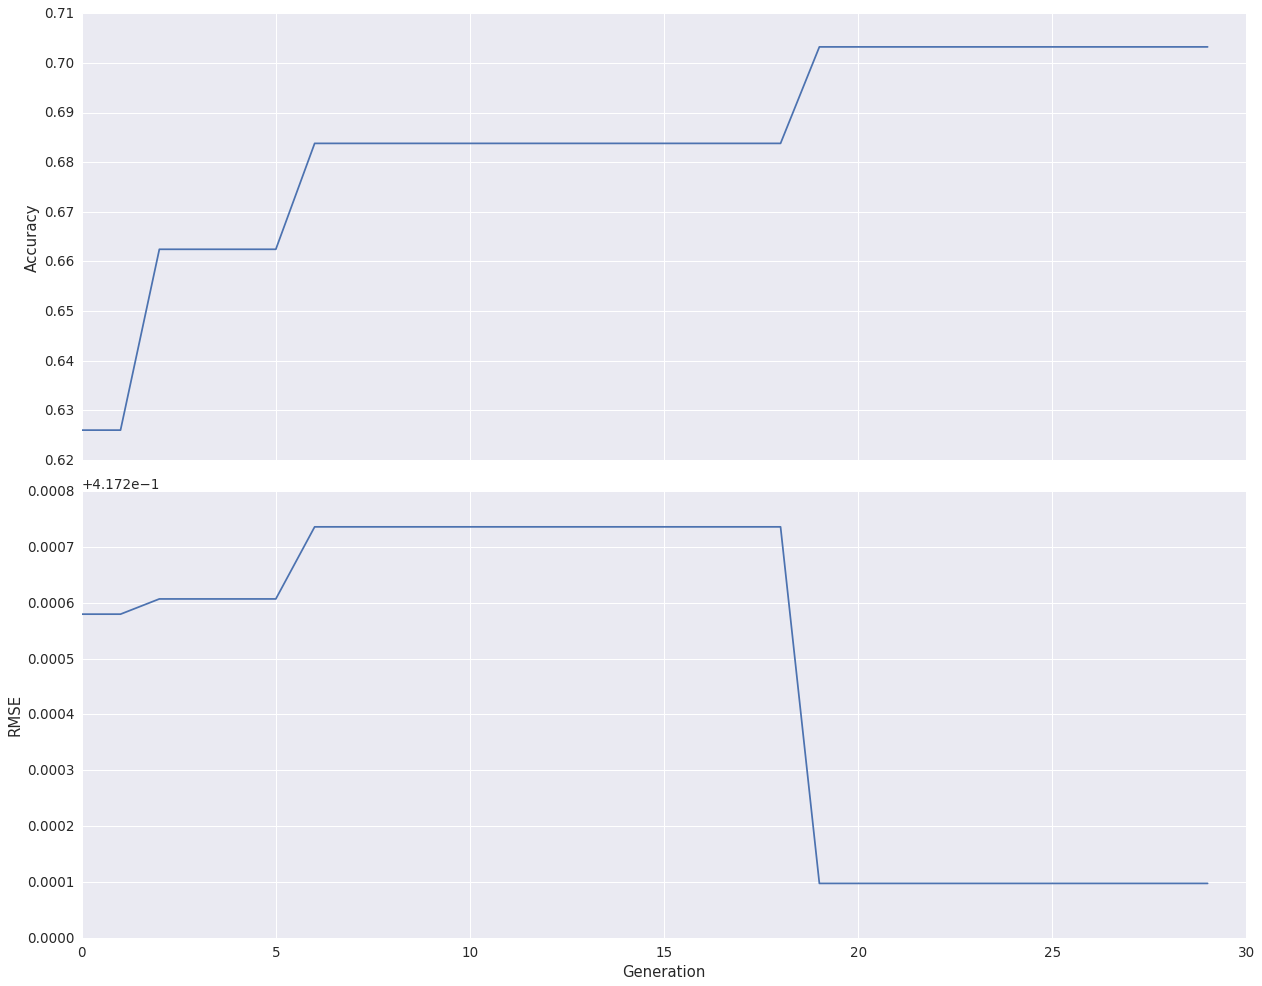

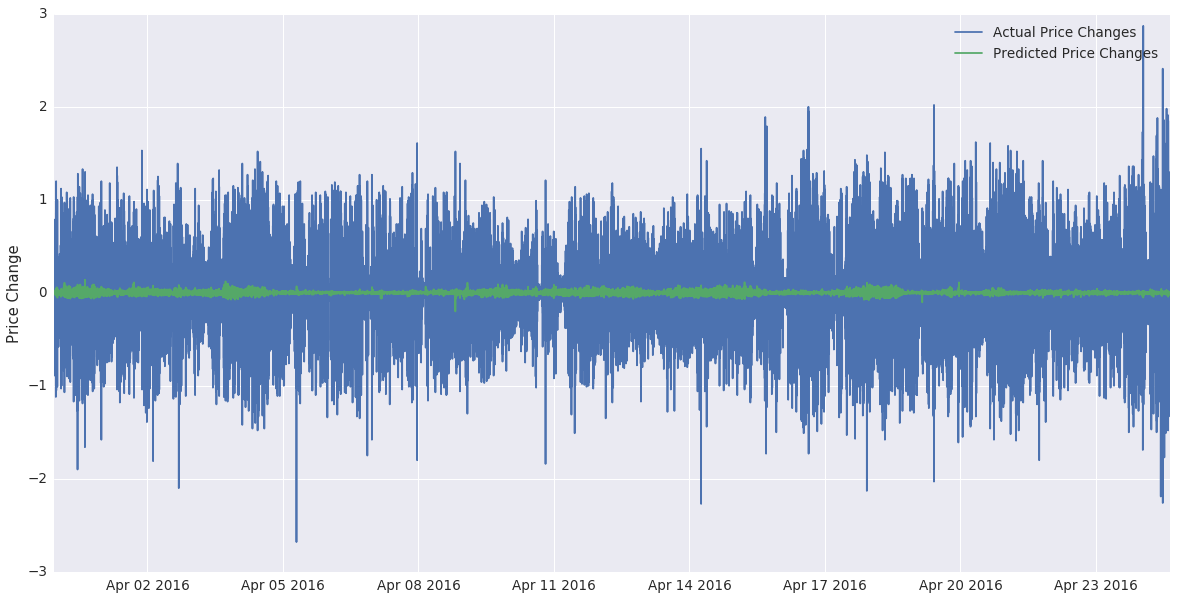

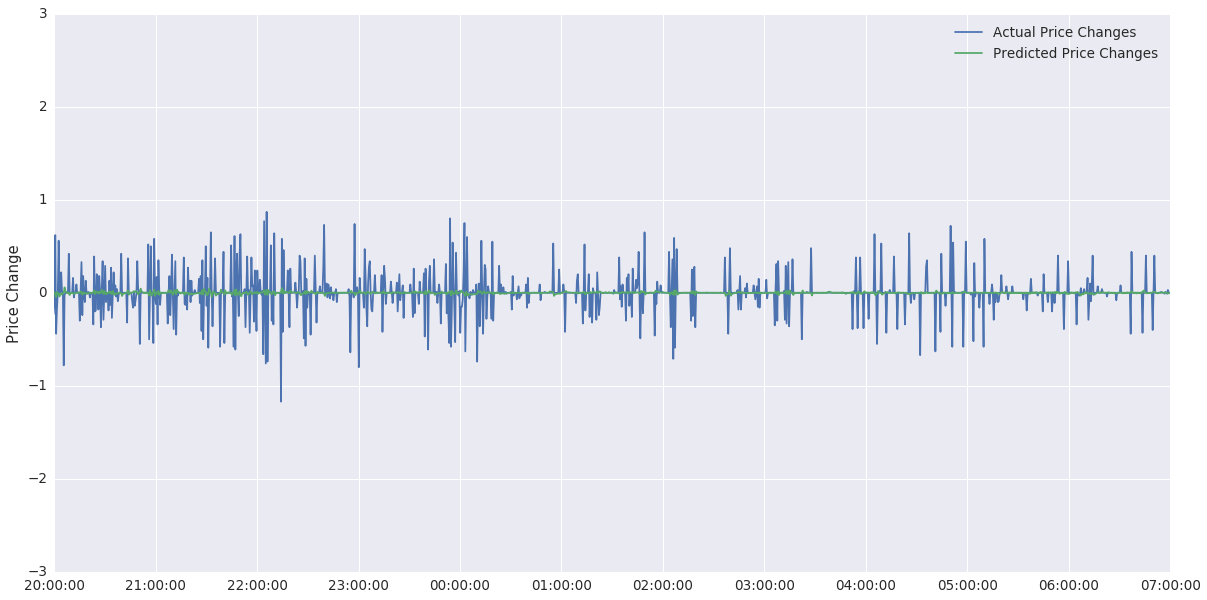

In [156]:
features = ['K360', 'K180', 'K60', 'D180',
            'D60', 'sD180', 'sD60', 'MOM60',
            'ROC60', 'LWR360', 'LWR180', 'LWR60',
            'ADOSC360', 'ADOSC60', 'DISP360',
            'DISP180', 'DISP60', 'OSCP60-180', 'RSI360',
            'RSI180', 'RSI60', 'CCI180']

evaluate(data30s.copy(), features)

/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

Scores [[ 0.53773825  0.52012418]
 [ 0.59661161  0.51915652]
 [ 0.59711986  0.51543031]
 [ 0.59957645  0.51904095]
 [ 0.59957645  0.51904095]
 [ 0.59957645  0.51904095]
 [ 0.59957645  0.51904095]
 [ 0.61575604  0.51661901]
 [ 0.61575604  0.51661901]
 [ 0.61575604  0.51661901]
 [ 0.61575604  0.51661901]
 [ 0.61575604  0.51661901]
 [ 0.61575604  0.51661901]
 [ 0.61575604  0.51661901]
 [ 0.61575604  0.51661901]
 [ 0.61575604  0.51661901]
 [ 0.61575604  0.51661901]
 [ 0.61575604  0.51661901]
 [ 0.61575604  0.51661901]
 [ 0.61575604  0.51661901]
 [ 0.61575604  0.51661901]
 [ 0.61575604  0.51661901]
 [ 0.61575604  0.51661901]
 [ 0.61575604  0.51661901]
 [ 0.61948327  0.51707297]
 [ 0.63032613  0.51868982]
 [ 0.63032613  0.51868982]
 [ 0.63032613  0.51868982]
 [ 0.63032613  0.51868982]
 [ 0.63032613  0.51868982]] 

Chromosome:  [0.006990904250406375, 0.00960943587009521] 



Results

Training set R2:  -0.0229463600213 , Test set R2:  -0.0484691106824
Training set RMSE:  0.390871591424 , Test 

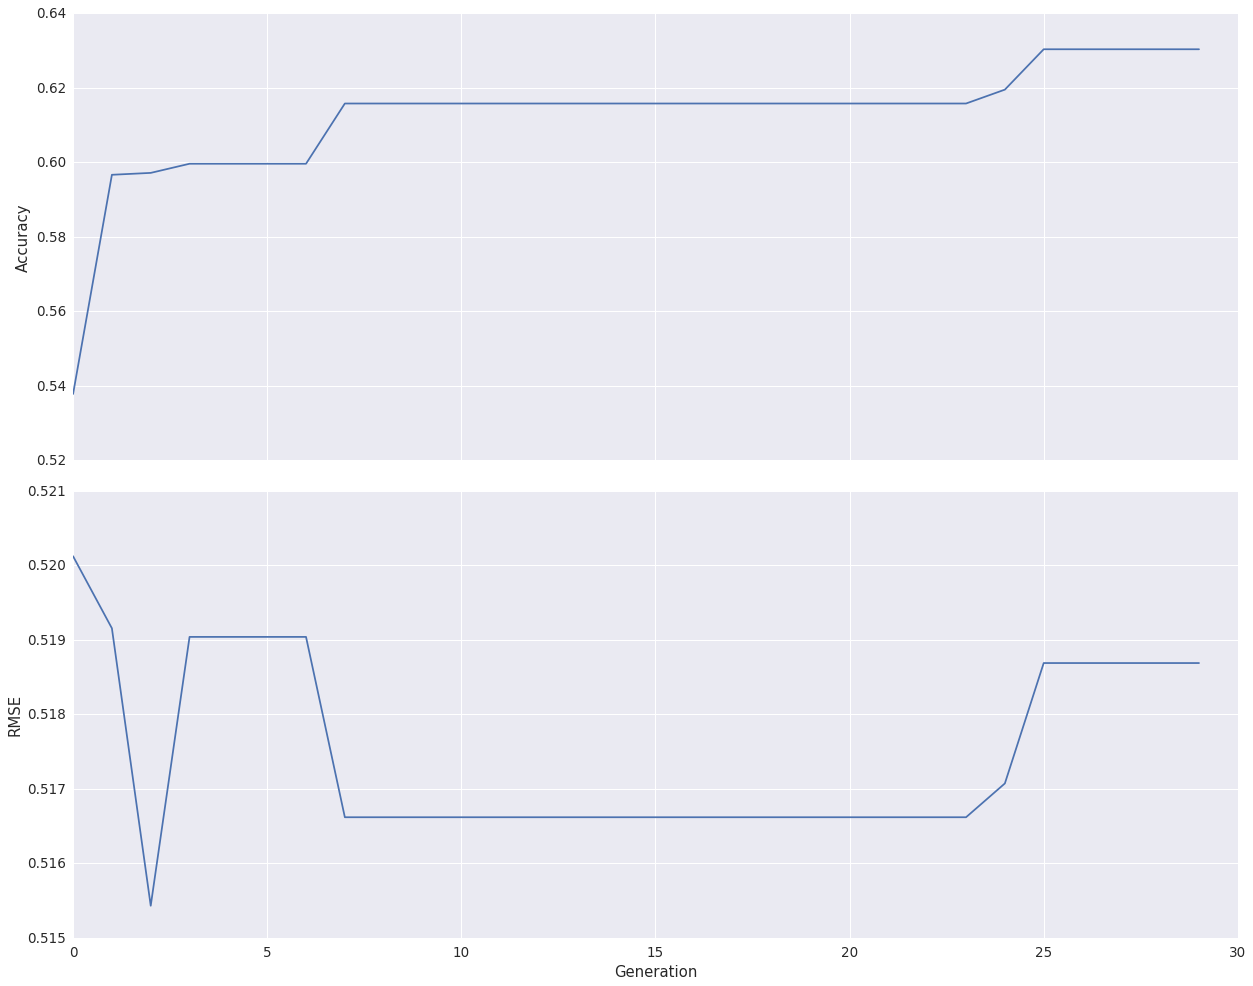

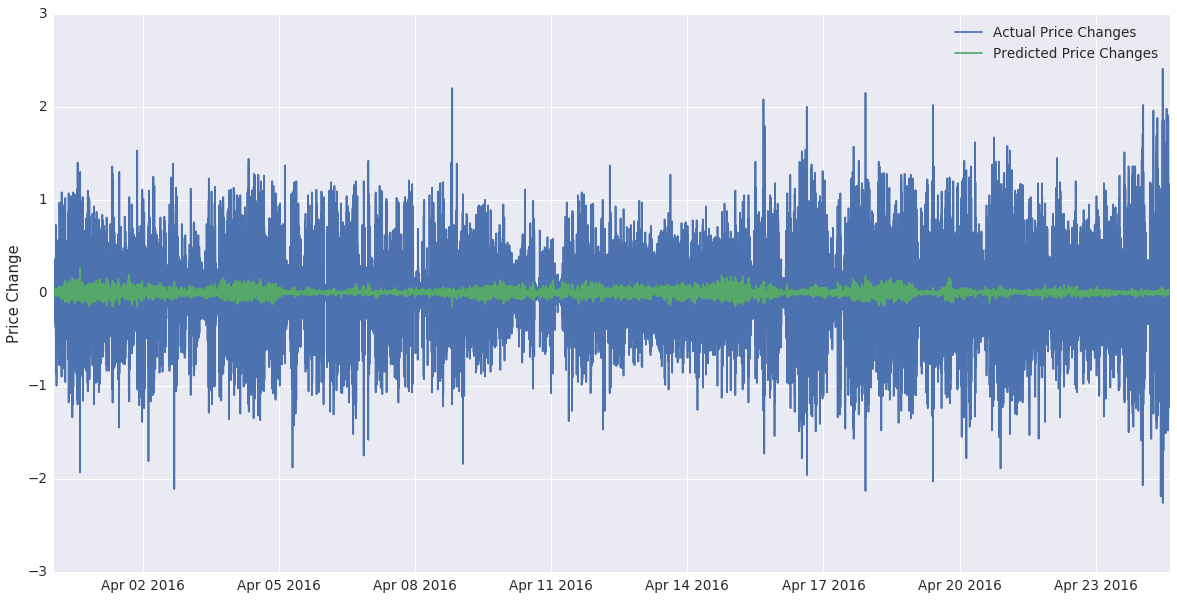

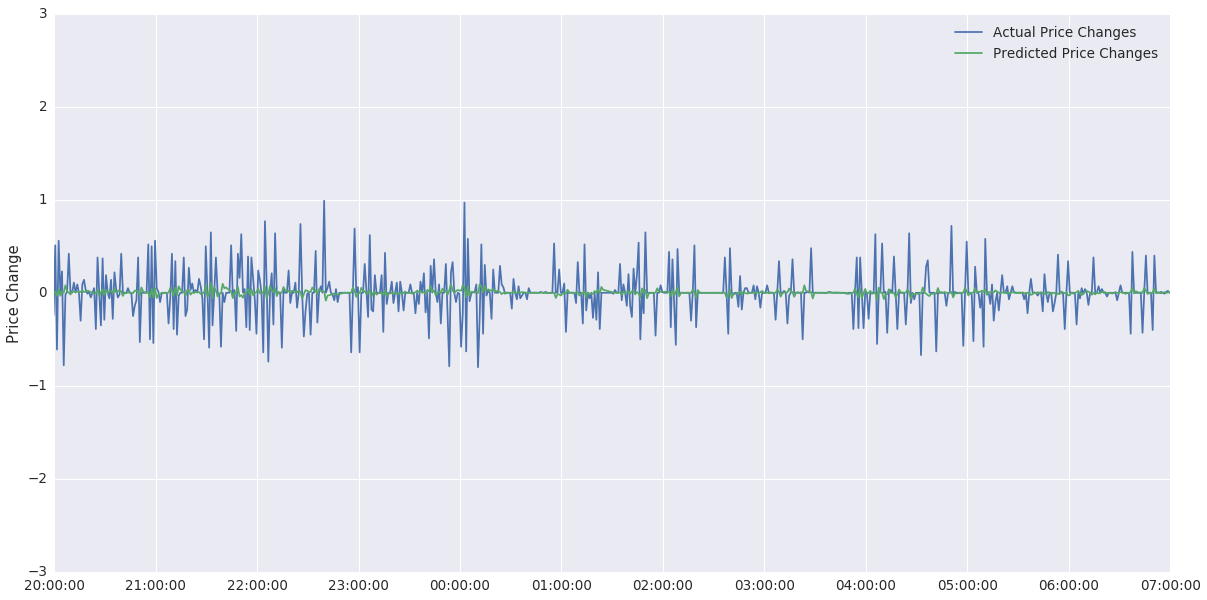

In [157]:
features = ['K360', 'K180', 'K60', 'D360', 'D180',
            'D60', 'sD180', 'sD60', 'MOM360', 'LWR360',
            'LWR180', 'LWR60', 'ADOSC360', 'ADOSC180',
            'ADOSC60', 'DISP360', 'DISP180', 'DISP60',
            'OSCP180-360', 'OSCP60-180', 'RSI360',
            'RSI180', 'RSI60', 'CCI180'] 

evaluate(data1m.copy(), features)

/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

Scores [[ 0.59164835  0.76369425]
 [ 0.59296703  0.76371962]
 [ 0.59296703  0.76371962]
 [ 0.59296703  0.76371962]
 [ 0.59296703  0.76371962]
 [ 0.59296703  0.76371962]
 [ 0.59296703  0.76371962]
 [ 0.59296703  0.76371962]
 [ 0.59296703  0.76371962]
 [ 0.59296703  0.76371962]
 [ 0.59296703  0.76371962]
 [ 0.59296703  0.76371962]
 [ 0.59296703  0.76371962]
 [ 0.59296703  0.76371962]
 [ 0.59296703  0.76371962]
 [ 0.5956044   0.76343441]
 [ 0.5956044   0.76343441]
 [ 0.5956044   0.76343441]
 [ 0.5956044   0.76343441]
 [ 0.5956044   0.76343441]
 [ 0.5956044   0.76343441]
 [ 0.5956044   0.76343441]
 [ 0.5956044   0.76343441]
 [ 0.5956044   0.76343441]
 [ 0.5956044   0.76343441]
 [ 0.5956044   0.76343441]
 [ 0.5956044   0.76343441]
 [ 0.5956044   0.76343441]
 [ 0.5956044   0.76343441]
 [ 0.5956044   0.76343441]] 

Chromosome:  [0.0004354762691528098, 0.0016955271527401507] 



Results

Training set R2:  0.0632068357817 , Test set R2:  0.106394098213
Training set RMSE:  0.565167970354 , Test 

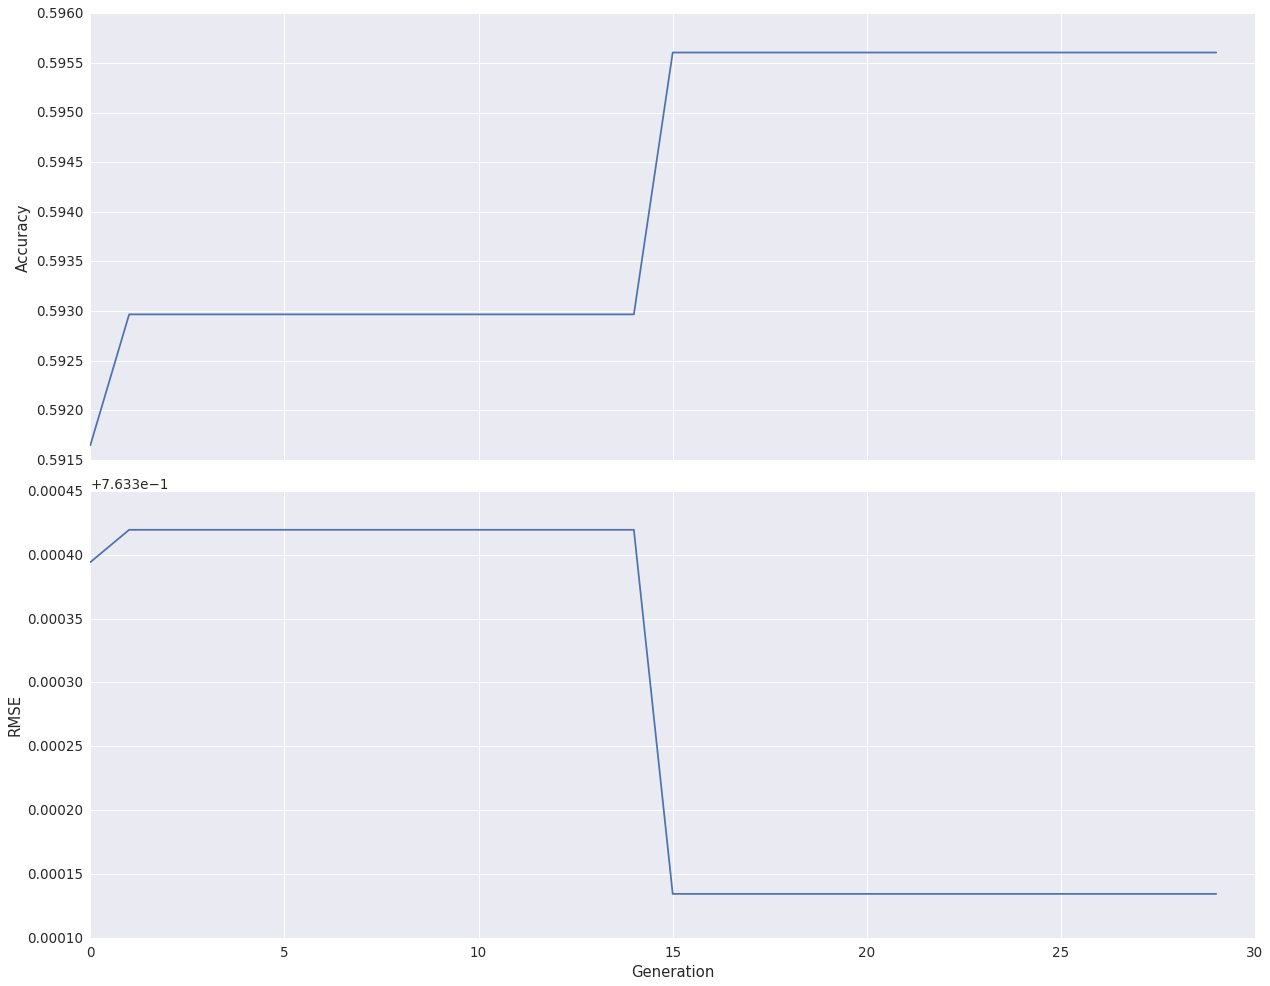

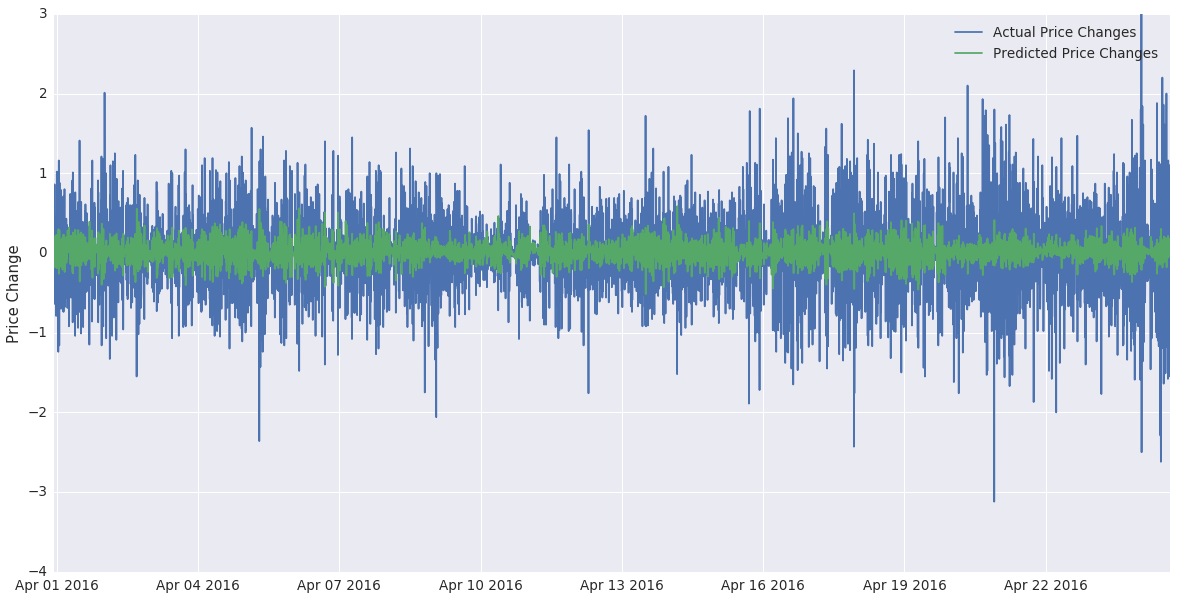

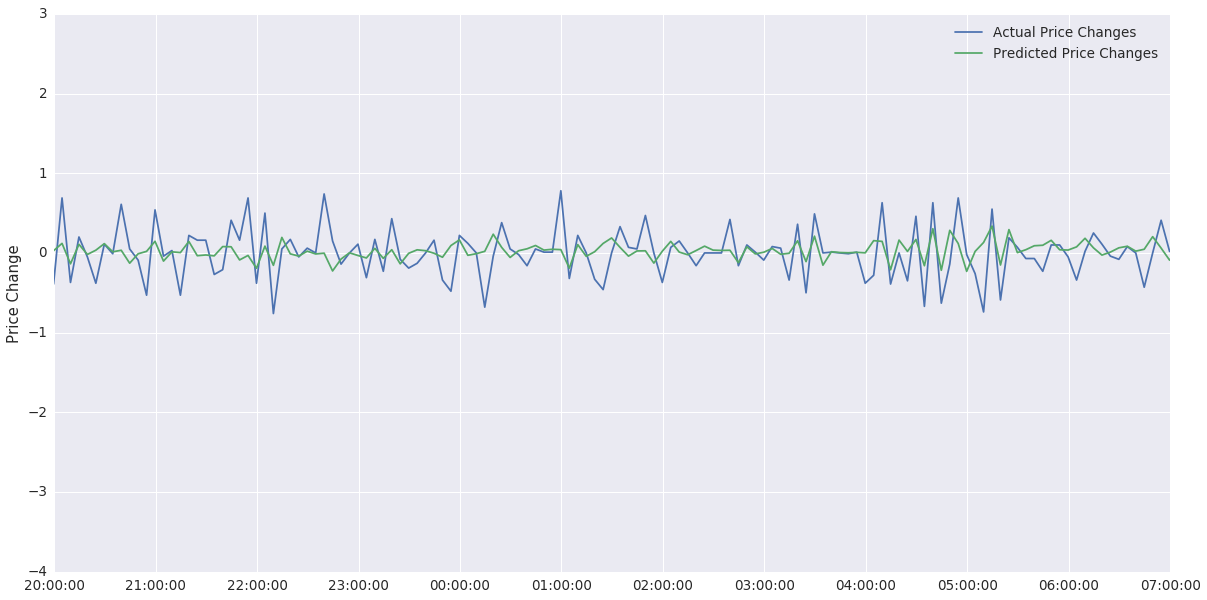

In [163]:
features = datas[2].drop(['Price', 'DELTAP'], axis = 1).columns

evaluate(data5m.copy(), features)

/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

Scores [[ 0.55493998  0.84572413]
 [ 0.55863343  0.8456463 ]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]
 [ 0.56509695  0.84526432]] 

Chromosome:  [0.009625318932782657, 0.008166267981888608] 



Results

Training set R2:  0.0434972537307 , Test set R2:  0.0753764198101
Training set RMSE:  0.610151437162 , Test s

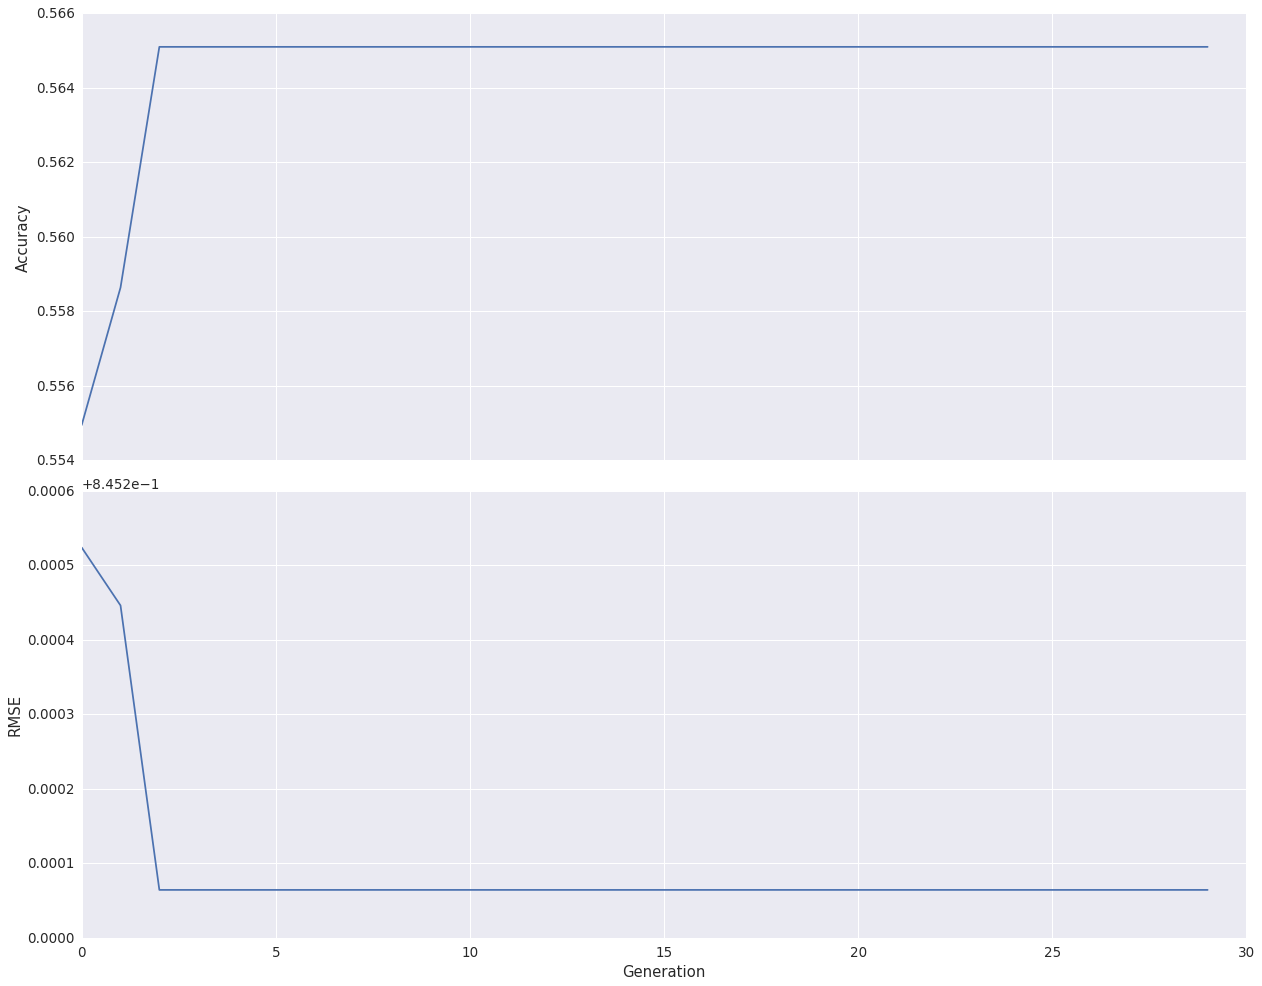

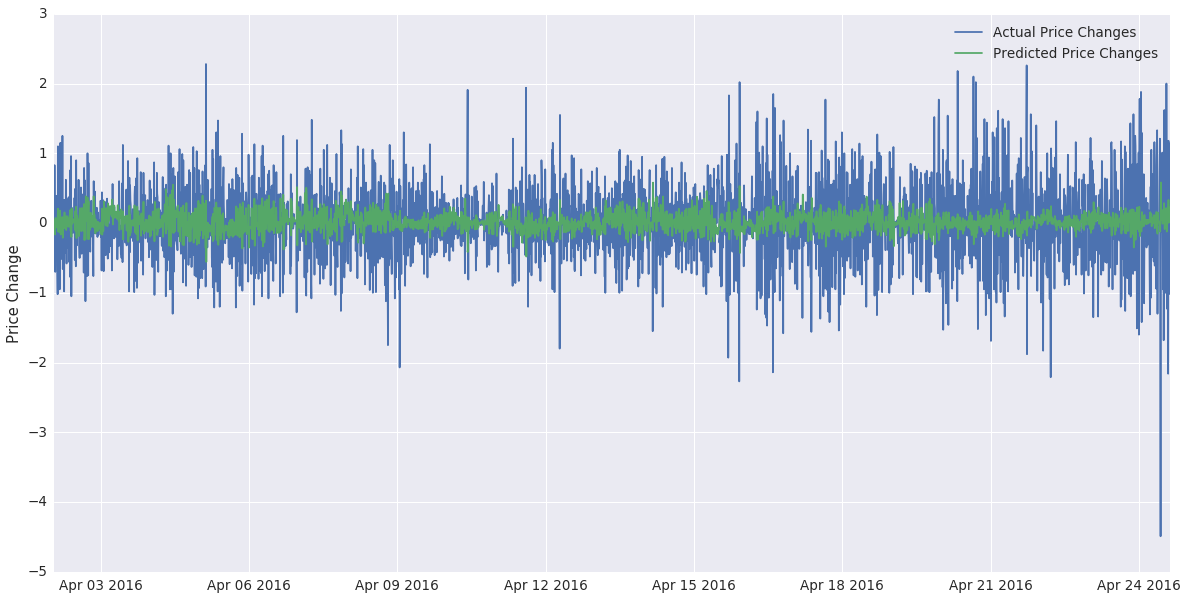

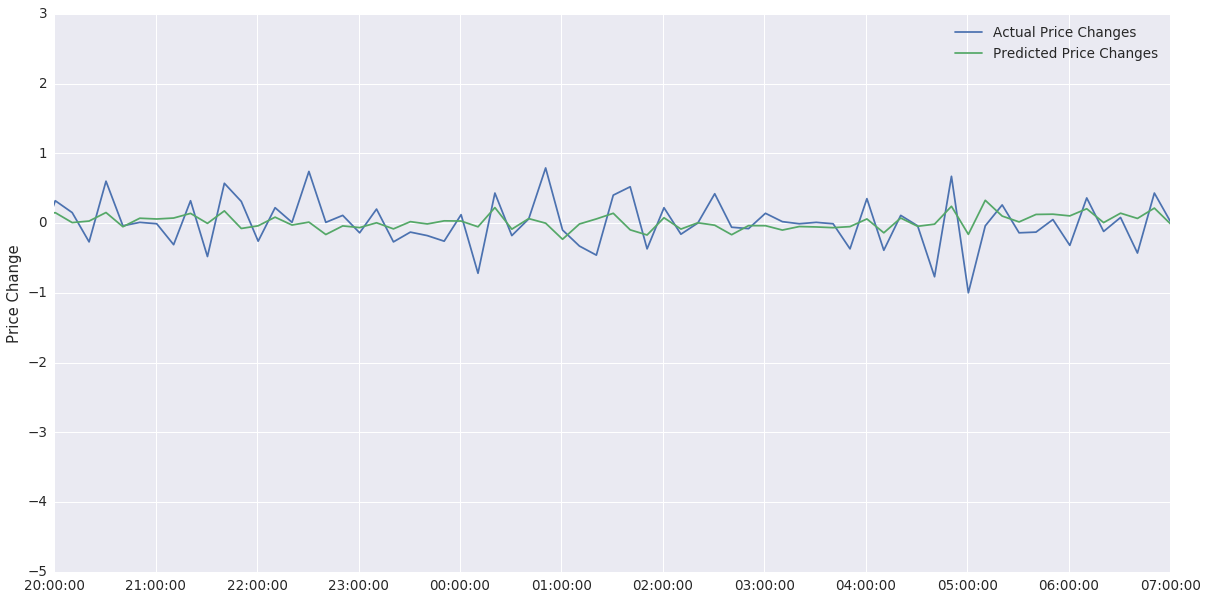

In [167]:
features = data10m.drop(['Price', 'DELTAP'], axis = 1).columns

evaluate(data10m.copy(), features)

# Backtesting

/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.60153846153846158

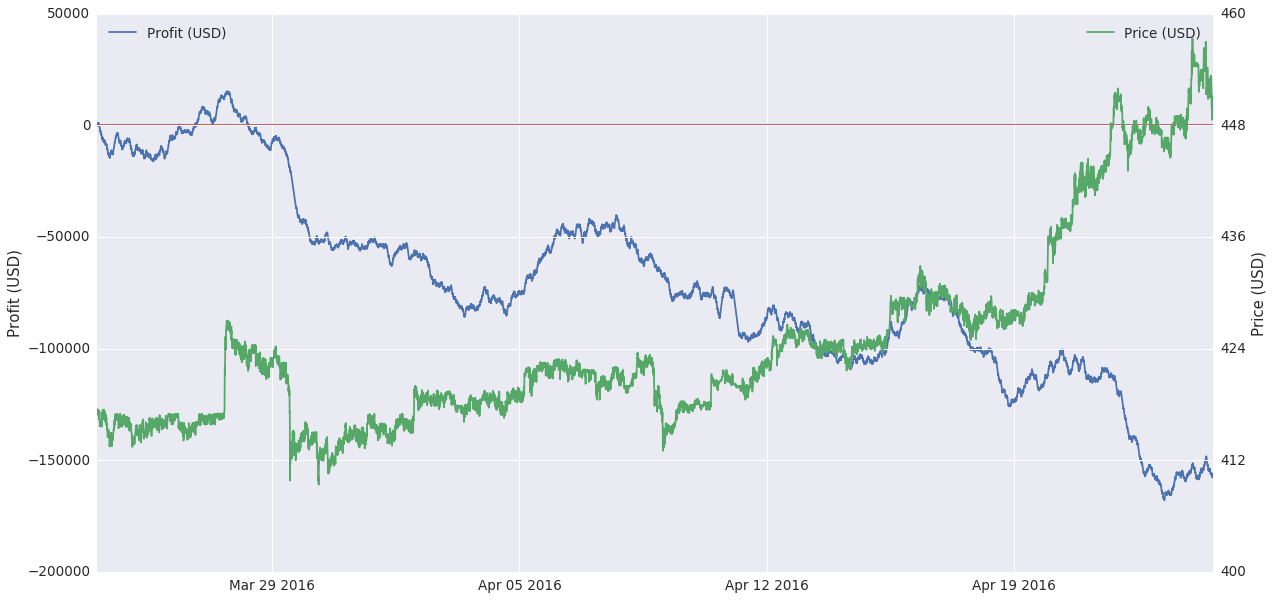

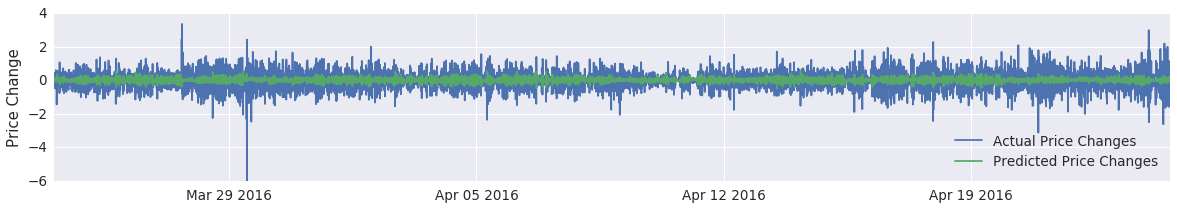

In [227]:
features = data5m.drop(['Price', 'DELTAP'], axis = 1).columns

X, y = data5m[features].copy(), data5m['DELTAP'].copy()
prices = data5m['Price'].copy()

train_dates = X.index[:int(0.6*len(X))]
test_dates = X.index[int(0.6*len(X)):]

X_train = X[train_dates[0]:train_dates[-1]]
y_train = y[train_dates[0]:train_dates[-1]]
    
X_test = X[test_dates[0]:test_dates[-1]]
y_test = y[test_dates[0]:test_dates[-1]]

scaler = preproc.StandardScaler()
for df in X_train.columns.tolist():
    scaler.fit(X_train[df].reshape(-1,1))
    X_train[df] = scaler.transform(X_train[df].reshape(-1,1))
    X_test[df] = scaler.transform(X_test[df].reshape(-1,1))
    
sgd = linear_model.SGDRegressor(shuffle = True, penalty = 'l2', epsilon = 0,
                                loss = 'epsilon_insensitive',
                                n_iter = np.ceil(10**6 / len(X_train)),
                                alpha = 0.0004, eta0 = 0.002)

pred = []
results = [0]
balance = 0
coins = 0

sgd.fit(X_train, y_train)

for i in range(len(X_test) - 1):
    x = X_test.ix[i]
    y = y_test.ix[i]
    prev_sign = np.sign(y_test.ix[i-1])
    pred_sign = np.sign(sgd.predict(x.reshape(1,-1)))
    curr_price = prices[i]
    
    if (pred_sign == 1 and  prev_sign == -1 and coins <= 0):
        balance = - curr_price
        coins = coins + 1
    if (pred_sign == -1 and  prev_sign == 1 and coins >= 0):
        coins = coins - 1
        balance = curr_price
    
    results.append(balance)
    pred.append(sgd.predict(x.reshape(1,-1)))
    sgd.partial_fit(x.reshape(1,-1), y.ravel(1,))

fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(111)
ax1.plot(y_test.index, np.cumsum(results),
         label = 'Profit (USD)')
ax1.axhline(color='r')
plt.ylabel('Profit (USD)')
ax2 = ax1.twinx()
ax2.plot(y_test.index,
         prices[test_dates[0]:test_dates[-1]],
         color = 'g', label = 'Price (USD)')
plt.ylabel('Price (USD)')
ax2.set_yticks(np.linspace(ax2.get_yticks()[0],
                           ax2.get_yticks()[-1],
                           len(ax1.get_yticks())))

ax1.legend(loc = 2)
ax2.legend()

fig = plt.figure(figsize = (20, 3))
plt.plot(y_test.index[:-1], y_test[:-1], label = 'Actual Price Changes')
plt.plot(y_test.index[:-1], pred, label = 'Predicted Price Changes')
plt.ylabel('Price Change')
plt.legend(loc = 4)

accuracy(y_test, pred)